In [1]:
import re

from PyPDF2 import PdfReader
import pandas as pd
fern_species = pd.read_excel("Species list.xlsx")


In [47]:
from tqdm.auto import tqdm

conditional_newline = lambda sp: '\s*\n?'.join(sp.split(' ')).replace('.', '\.').replace('(', '\(').replace(')', '\)').replace('[', '\[').replace(']', '\]')
sp_descriptions = pd.DataFrame()
for fam in tqdm(fern_species.Family.unique()):
    text = ""
    with open(f"descriptions/{fam}.pdf", "rb") as pdf_file:
        read_pdf = PdfReader(pdf_file)
        for i, page in enumerate(read_pdf.pages):
            if i < 5:
                continue
            tx = page.extract_text()
            if tx.split("\n")[0].startswith('References'):
                # print(f"Breaking at page {i}")
                break
            text += page.extract_text()
    text = re.sub(r'[^\S\r\n]+', ' ', text)

    fam_species = fern_species[fern_species.Family.eq(fam)].Species.unique()
    sp_dict = {}
    for i, species in enumerate(fam_species):
        species = species
        if (cnt := len(re.findall(conditional_newline(species), text))) == 0:
            print(f"{fam} | {species} wrongly appearing (count: {cnt})")
            foo
        # start = text.find(species)
        # start is the first character of the species name assuming to find it in the text
        # with potentially some '\n' characters in between
        start = re.search(conditional_newline(species), text).start()
        end = [re.search(conditional_newline(sp), text).start() for sp in fam_species]
        end = min([e for e in end if e and e > start] + [len(text)])
        name_sp = species.split(')')[0] + ')'
        if name_sp not in sp_dict.keys():
            sp_dict[name_sp] = text[start:end]
        else:
            sp_dict[name_sp] += '\n' + text[start:end]

    sp_descriptions = pd.concat([sp_descriptions, pd.DataFrame(sp_dict.items(), columns=['Species', 'Description']).assign(Family=fam)], ignore_index=True)


def desc_to_sections(desc):
    """
    Split the description into sections:
    "Etymology", "Vernacular name", "Distribution", "Altitudinal range", "Biostatus", "Habitat", "First record ", "Recognition ", "Cytology", "Hybridisation", "Notes "
    not all the sections will be present in all descriptions, if present, they start with the section name followed by a colon, up to the next named section or the end of the description
    """
    sections = ["Etymology", "Vernacular name", "Distribution", "Altitudinal range", "Biostatus", "Habitat", "First record", "Recognition", "Cytology", "Hybridisation", "Notes"]
    section_dict = {}
    for i, section in enumerate(sections):
        if i == len(sections) - 1:
            section_dict[section] = desc
        else:
            start = re.search(fr"{section}s?:", desc)
            start = start.end() if start else -1
            if start == -1:
                continue
            end = re.search(fr"{sections[i+1]}s?:", desc)
            end = end.start() if end else -1

            this_desc = desc[start:end].strip()

            section_dict[section] = re.sub(r'\n+', ' ', this_desc.strip())
    return pd.Series(section_dict)

extra = sp_descriptions.Description.apply(desc_to_sections)  
sp_descriptions = pd.concat([sp_descriptions, extra], axis=1).drop(columns='Description')

  0%|          | 0/32 [00:00<?, ?it/s]

In [50]:
sp_descriptions.to_excel("fern_descriptions.xlsx", index=False)

# Extract features

In [2]:
sp_descriptions = pd.read_excel("fern_descriptions.xlsx").set_index('Species')

In [3]:
extra_features_df = pd.read_excel("../Words before and after traits_v2.xlsx", sheet_name="FernPrecedingWords")
extra_features_df = extra_features_df[
    :extra_features_df[extra_features_df.Rhizome.str.startswith('Sentences that talk a', na=False)].index[0]
    ].map(lambda s:s.lower().strip() if type(s) == str else s)

extra_features = extra_features_df.to_dict('list')
extra_features = {k.title().replace(' ', ''): [x for x in v if str(x) != 'nan'] for k, v in extra_features.items()}

In [4]:
unit = '[m|c|d|μ]?m'
number = r"(\d+\.?\d*)"
full_regex = rf"(({number}\s?-\s?)?{number})?({number}\s?-\s?)?{number}\s*{unit}(-wide)?(-long)?"

In [57]:
tmp = []
anomalies = set() # species with anomalies

def extract_features(i, feats:list):
	features = {}
	for feat in feats:
		if len(feat) < 1:
			continue
		feat = feat.replace(',', ' ')
		measures = re.finditer(full_regex, feat)
		for measure in measures:
			found = None
			for key, values in extra_features.items():
				if key.startswith('Habit'):
					# categorical feature, append all the values present in feat
					features['Habit'] = ';'.join([v for v in values if v.lower() in re.split(r'[^\w]', feat.lower())])
					continue
				if key.startswith('Venation'):
					# categorical feature, store feat as it is
					# features['Venation'] = feat
					continue

				feat = feat[:-1] if feat[-1] in ['.', ';'] else feat # remove any of .; at the end of the sentence
				matched_word = list(re.finditer( r'\b('+ '|'.join([w for w in set(values)]) + r')\b', feat.lower()))
				
				if any(matched_word):
				# "*Secondary* pinnae decreasing very gradually in length along each ~primary~ pinna to the distal end..." is supposed to be Secondary
					if key == 'Laminae' and 'primary' in feat.lower() and len(features.get('Laminae', [])) >= 2:
						continue
					if key == 'PrimaryPinnae' and 'secondary' in feat.lower() and len(features.get('PrimaryPinnae', [])) >= 2:
						continue
					matched_word = [w for w in matched_word if w.span()[0] < measure.span()[0]]
					if not any(matched_word):
						continue
					matched_word = sorted(matched_word, key=lambda word: word.span()[1] - measure.span()[0])[0]
					this_distance = abs(matched_word.span()[1] - measure.span()[0])
					# this_distance = abs(word_match_position - measure_position)

					if key in ['Stipe', 'Laminae']:
						hair_or_scale_position = list(re.finditer(r'(hair|scale)', feat.lower()))
						# C1: Se nella frase dello stipe trovi le keyword "hair", "hairs", "scale", "scales", i valori dopo queste keyword vanno ignorati.
						if any(hair_or_scale_position) and hair_or_scale_position[0].start() < measure.start():
							continue
					if found:
						if (any([w in feat.lower() for w in ['achene', 'cypsela']]) and {key, found[0]} == {'FruitSize', 'SeedSize'}) or\
						   (any([w in feat.lower() for w in ['stigma-style']]) and {key, found[0]} == {'StigmaSize', 'StyleSize'}) or\
						   (any([w in feat.lower() for w in ['floret']]) and {key, found[0]} == {'RayFloretsSize', 'DiskFloretSize'}):
							pass
							# print(f'OK>> Multiple features found ({found}, {key}) in "{feat}"')
						else:
							if this_distance >= found[1]:
								continue
							features[found[0]].remove(found[2])
							anomalies.add(i)

					found = (key, this_distance, measure.group())
					if key in features:
						features[key].append(measure.group())
					else:
						features[key] = [measure.group()]
	return pd.Series(features)



In [29]:
def string_preprocessing(s):
	s = s.replace('\xa0', ' ').replace('×', 'x').replace('–', '-').replace('·', '.') # remove non-breaking space and replace multiplication sign with x
	s = re.sub(r'(?<=xcluding)\s+[\w-]+', ' ', s) # remove each word following "excluding" (Mericarps (excluding style) 2.5-3.0 mm should point to "Mericarps")
	s = re.sub(fr'-?\(-?{number}-?\)-?', '', s) # remove all parentesis surrounding a number and the number inside (e.g. (-1.5) --> **)
	# s = s.replace('--', '-').replace('-.', '-').replace('..', '.')
	# s = s.replace('(', '').replace(')', '')
	# s = re.sub(r'\s(c|ca|o)\.', ' foo ', s) # remove all ' c.'
	s = re.sub(rf'(?<=\d)\s+(?={unit})', '', s) # remove all spaces before measures (mm, cm, dm, m, these strings only if padded by a space)
	s = re.sub('m long;?', 'm-long', s) # remove space between measure and "long" (e.g. 2 mm long --> 2 mm-long)
	s = re.sub('m wide;?', 'm-wide', s) # remove space between measure and "wide" (e.g. 2 mm wide --> 2 mm-wide)
	s = re.sub(r'\s*-\s*', '-', s) # remove spaces around hyphens
	s = re.sub(r'(?<=\d)\s*\.(?=\d)', '.', s) # remove spaces before dot if followed and preceded by a number
	s = re.sub(r'(?<=\s)\.(?=\d)', '0.', s) # add a 0 before a dot if it is preceded by a space and a "not number" and followed by a number (e.g. foo .5 --> foo 0.5)
	# s = re.sub(r'(?<=[\dm])\s*x\s*(?=\d+)', 'x', s) # remove spaces around x in formulas
	s = re.sub(rf'(;\s*)({full_regex})', r' \2', s) # point to any ';' preceding a measure (full_regex) and remove it, without removing the measure
	return s

In [42]:
features = sp_descriptions.Etymology.fillna('') + ' ' + sp_descriptions['Vernacular name'].fillna('')
# delimiter any of '. ', '.\n' and similar (all the dots not followed by numbers and not preceded by ' c', enforced with a negative lookbehind)
delimiter = r'(?<! c)\.(?!\d)'
tmp = features.apply(string_preprocessing).str.split(delimiter)
tmp[tmp.index.str.contains('Deparia petersenii subsp')].reset_index().apply(lambda x: extract_features(x.Species, x[0]), axis=1)

 Stipes 35-480mm  blackish-brown proximally  yellow-brown or rarely red-brown distally; bearing multicellular pale brown hairs up to 0.5mm-long  and narrowly ovate  pale to dark brown scales up to 9mm-long and 2.5mm-wide
 Rachises yellow-brown or rarely red-brown  becoming green distally  winged distally  adaxially grooved  bearing multicellular hairs up to 0.5mm-long  and scales up to 1.5mm-long hairs more abundant distally


,Rhizome,Habit,Stipe,Frond,Unnamed:17,Rachis,Laminae,PrimaryPinnae,SecondaryPinnae,Sori,Indusia
0,"[260mm-long, 2.5-7mm, 4-6mm-long, 0.8-2mm-wide...",,"[5-40mm, 35-480mm]",[180-910mm-long],"[0.5mm-long, 9mm-long, 2.5mm-wide, 1mm-long, 1...","[0.5mm-long, 1.5mm-long]","[115-510mm-long, 40-270mm-wide]","[20-195mm-long, 10-75mm-wide, 1mm]","[5-40mm-long, 3-10mm-wide]",[],[1-3mm-long]


In [58]:
features = sp_descriptions.Etymology.fillna('') + ' ' + sp_descriptions['Vernacular name'].fillna('')
# delimiter any of '. ', '.\n' and similar (all the dots not followed by numbers and not preceded by ' c', enforced with a negative lookbehind)
delimiter = r'(?<! c)\.(?!\d)'
features = features.apply(string_preprocessing).str.split(delimiter).reset_index().apply(lambda x: extract_features(x.Species, x[0]), axis=1)
features = features.map(lambda x: '; '.join(x) if not isinstance(x, float) else x)
features.index = sp_descriptions.index
features[features.notna().sum(axis=1) > 0].to_csv('processed_features_fern.csv')

<Axes: title={'center': 'Missing values in the features'}>

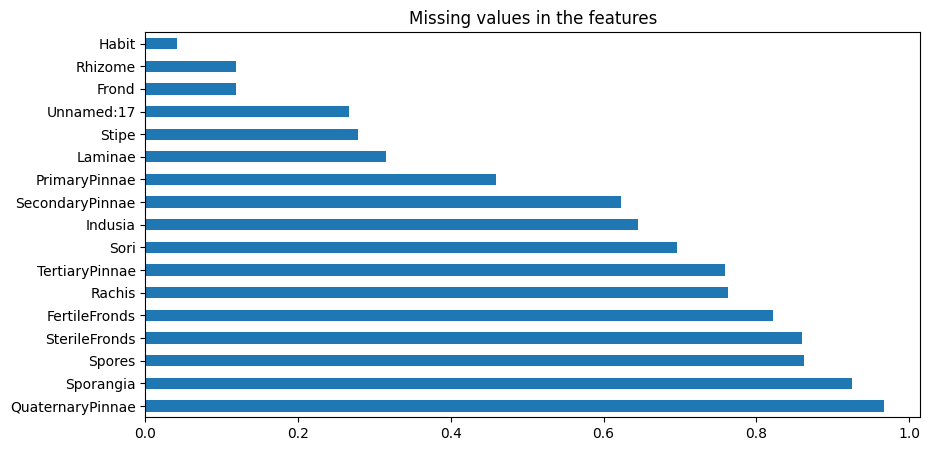

In [70]:
(features.isna().sum()/features.shape[0]).sort_values(ascending=False).plot(kind='barh', figsize=(10, 5), title='Missing values in the features')

In [71]:
features.Habit.value_counts()

Habit
                          256
c; r; e; e; p; i; n; g      3
Name: count, dtype: int64

In [65]:
features[['Laminae', 'PrimaryPinnae', 'SecondaryPinnae']].apply(processFeat, axis=0)

TypeError: expected string or bytes-like object

In [52]:
.5*(115+510)

312.5

In [63]:
import numpy as np
import pint
ureg = pint.UnitRegistry()

def range_to_num(s):
	metric = next(re.finditer(unit, s))
	value = s[:metric.start()]
	if '-' in value:
		value = np.array(value.split('-')).astype(float).mean()
	else:
		value = float(value)
	# return ureg.Quantity(value, metric.group())
	return value


s = '115-510mm-long; 40-270mm-wide;...'
def processFeat(s:str):
	"""
	if wide and long are in s, split the string keeing the first 2 occurrences having wide and long
	"""
	if 'wide' in s and 'long' in s:
		slist = s.split(';')
		long = [x.split('-long')[0].strip() for x in slist if 'long' in x][0]
		wide = [x.split('-wide')[0].strip() for x in slist if 'wide' in x][0]
		m = (long, wide)

		m = {k: range_to_num(x) for x, k in zip(m, ['long', 'wide'])}
		return pd.Series(m)
	else:
		return range_to_num(s)
	
processFeat(s)


long    312.5
wide    155.0
dtype: float64